# **Twitter Abuse Detection**
---

### **IMPORTING DEPENDENCIES AND DATASET**

---



In [61]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import torch
import random

In [63]:
df = pd.read_excel(r"FountaDataset.xlsx")
df.drop(columns=["No.Of Votes"],axis=1,inplace=True)
df.rename(columns={'Majority Label': 'class',"Tweets":"tweet"}, inplace=True)
df = df.dropna()

In [64]:
df1 = df.copy()

In [65]:
df['class'].value_counts()

class
normal     53850
abusive    27149
spam       14030
hateful     4965
Name: count, dtype: int64

In [66]:
df1['class'] = df1['class'].map({
    'normal': 'Neutral',
    'abusive': 'Abusive',
    'hateful': 'Hate',
    'spam':'Neutral'
})

In [67]:
# Data preprocessing
tweet = df1['tweet'].tolist()
true_label = df1['class'].tolist()

In [68]:
sample_size = 3000 
sample_indices = random.sample(range(len(df)), sample_size)

# **Transformer Embeddings**

In [69]:
#!pip install transformers
# A dependency of the preprocessing for BERT inputs
#!pip install -q tensorflow-text
!pip install -q tf-models-official

In [70]:
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow.keras.backend as K
from scipy.stats import spearmanr
from math import floor, ceil
from transformers import *

np.set_printoptions(suppress=True)
print(tf.__version__)

import shutil

from official.nlp import optimization  # to create AdamW optmizer

tf.get_logger().setLevel('ERROR')

2.10.1


In [71]:
df0 = df.copy()
c=df0['class']
df0.rename(columns={'tweet' : 'text','class' : 'category'},inplace=True)

In [72]:
a=df0['text']
b=df0['category'].map({0: 'hate_speech', 1: 'offensive_language',2: 'neither'})

In [73]:
df= pd.concat([a,b,c], axis=1)
df.rename(columns={'class' : 'label'},inplace=True)
df

,text,category,label
0,Beats by Dr. Dre urBeats Wired In-Ear Headphon...,NaN,spam
1,RT @Papapishu: Man it would fucking rule if we...,NaN,abusive
2,It is time to draw close to Him &#128591;&#127...,NaN,normal
3,if you notice me start to act different or dis...,NaN,normal
4,"Forget unfollowers, I believe in growing. 7 ne...",NaN,normal
...,...,...,...
99991,RT @shangros: my fucking queen https://t.co/wa...,NaN,abusive
99992,#Osteporosis treated with #PEMF - rebuild bone...,NaN,normal
99993,@LGUSAMobile why does my phone screen keeps fl...,NaN,normal
99994,#bigdata vs. #reality ... but equally applies ...,NaN,normal


In [74]:
df.groupby('label').count()

,text,category
label,,
abusive,27149,0
hateful,4965,0
normal,53850,0
spam,14030,0


In [75]:
### Splitting the data between train, validation and test sets:
X_train_, X_test, y_train_, y_test = train_test_split(
    df.index.values,
    df.label.values,
    test_size=0.10,
    random_state=42,
    stratify=df.label.values,
)

X_train, X_val, y_train, y_val = train_test_split(
    df.loc[X_train_].index.values,
    df.loc[X_train_].label.values,
    test_size=0.10,
    random_state=42,
    stratify=df.loc[X_train_].label.values,
)

In [76]:
!pip install WordCloud STOPWORDS

<class 'set'>


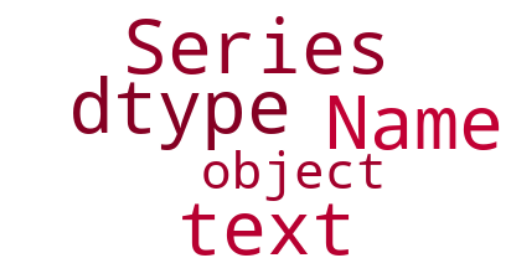

In [77]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
stopwords.add("RT")

print(type(STOPWORDS))

import random

def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 344
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=60,
                          random_state=42
                         ).generate(str(df.loc[df["category"]=="offensive_language"].text))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()

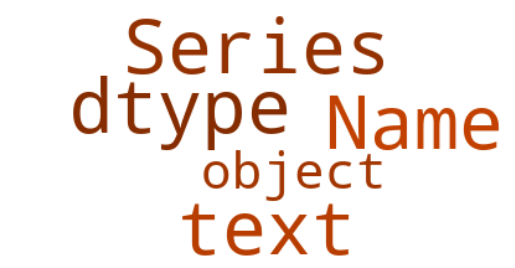

In [78]:
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 20
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=60,
                          random_state=42
                         ).generate(str((df.loc[df["category"]=="neither"].text)))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()


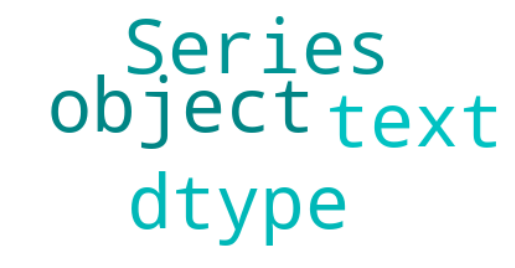

In [79]:
stopwords.add("Name")

def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 180
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=60,
                          random_state=42
                         ).generate(str((df.loc[df["category"]=="hate_speech"].text)))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()


In [80]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'
#bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/1',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1


In [81]:
#!pip -q install langchain huggingface_hub transformers sentence_transformers

In [82]:
pipe = pipeline("text-classification", model="igmarco/clasificador-hate_speech_offensive")

loading configuration file config.json from cache at C:\Users\aksha/.cache\huggingface\hub\models--igmarco--clasificador-hate_speech_offensive\snapshots\e73a8f19eb0633f02c898328f48c1a668d92837e\config.json
Model config BertConfig {
  "_name_or_path": "igmarco/clasificador-hate_speech_offensive",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification

In [89]:
df1

,tweet,class
0,Beats by Dr. Dre urBeats Wired In-Ear Headphon...,Neutral
1,RT @Papapishu: Man it would fucking rule if we...,Abusive
2,It is time to draw close to Him &#128591;&#127...,Neutral
3,if you notice me start to act different or dis...,Neutral
4,"Forget unfollowers, I believe in growing. 7 ne...",Neutral
...,...,...
99991,RT @shangros: my fucking queen https://t.co/wa...,Abusive
99992,#Osteporosis treated with #PEMF - rebuild bone...,Neutral
99993,@LGUSAMobile why does my phone screen keeps fl...,Neutral
99994,#bigdata vs. #reality ... but equally applies ...,Neutral


In [90]:
custom_class_mapping = {
    0: "Hate",
    1: "Abusive",
    2: "Neutral",
}

In [91]:
for class_id, new_label in custom_class_mapping.items():
    pipe.model.config.id2label[class_id] = new_label

In [92]:
updated_output_classes = pipe.model.config.id2label
print(updated_output_classes)

{0: 'Hate', 1: 'Abusive', 2: 'Neutral'}


In [93]:
correctly_classified = 0
incorrectly_classified = 0

true_labels = []  # To store true labels
predicted_labels = []  # To store predicted labels

In [94]:
df1

,tweet,class
0,Beats by Dr. Dre urBeats Wired In-Ear Headphon...,Neutral
1,RT @Papapishu: Man it would fucking rule if we...,Abusive
2,It is time to draw close to Him &#128591;&#127...,Neutral
3,if you notice me start to act different or dis...,Neutral
4,"Forget unfollowers, I believe in growing. 7 ne...",Neutral
...,...,...
99991,RT @shangros: my fucking queen https://t.co/wa...,Abusive
99992,#Osteporosis treated with #PEMF - rebuild bone...,Neutral
99993,@LGUSAMobile why does my phone screen keeps fl...,Neutral
99994,#bigdata vs. #reality ... but equally applies ...,Neutral


In [ ]:
for row_num in sample_indices:
    row = df1.loc[row_num]
    text = row['tweet']
    true_label = row['class']

    # Use the model to make predictions
    predicted_label = pipe(text)[0]["label"]

    # Update the predicted_label in the dataframe
    df1.at[row_num, 'predicted_column'] = predicted_label

    # Store true and predicted labels for later analysis
    true_labels.append(true_label)
    predicted_labels.append(predicted_label)
    print(f"Row {row_num} - True Label: {true_label}, Predicted Label: {predicted_label}")

    # Check if the prediction is correct
    if true_label == predicted_label:
        correctly_classified += 1
    else:
        incorrectly_classified += 1

# Print the total correct and incorrect classifications
print(f"Correctly classified: {correctly_classified}")
print(f"Incorrectly classified: {incorrectly_classified}")

Row 37377 - True Label: Neutral, Predicted Label: Neutral
Row 85818 - True Label: Neutral, Predicted Label: Neutral
Row 31155 - True Label: Abusive, Predicted Label: Abusive
Row 75913 - True Label: Neutral, Predicted Label: Neutral
Row 83726 - True Label: Neutral, Predicted Label: Neutral
Row 56605 - True Label: Abusive, Predicted Label: Abusive
Row 74606 - True Label: Neutral, Predicted Label: Neutral
Row 22271 - True Label: Abusive, Predicted Label: Abusive
Row 3887 - True Label: Abusive, Predicted Label: Abusive
Row 34488 - True Label: Neutral, Predicted Label: Neutral
Row 40459 - True Label: Neutral, Predicted Label: Neutral
Row 80991 - True Label: Neutral, Predicted Label: Neutral
Row 84832 - True Label: Abusive, Predicted Label: Abusive
Row 50248 - True Label: Neutral, Predicted Label: Neutral
Row 88108 - True Label: Neutral, Predicted Label: Neutral
Row 54123 - True Label: Neutral, Predicted Label: Neutral
Row 5945 - True Label: Neutral, Predicted Label: Neutral
Row 6945 - True 

Row 21621 - True Label: Abusive, Predicted Label: Neutral
Row 57331 - True Label: Neutral, Predicted Label: Abusive
Row 74630 - True Label: Neutral, Predicted Label: Neutral
Row 97980 - True Label: Neutral, Predicted Label: Neutral
Row 77670 - True Label: Neutral, Predicted Label: Neutral
Row 43629 - True Label: Neutral, Predicted Label: Neutral
Row 37448 - True Label: Abusive, Predicted Label: Abusive
Row 27121 - True Label: Neutral, Predicted Label: Neutral
Row 45578 - True Label: Neutral, Predicted Label: Neutral
Row 89103 - True Label: Abusive, Predicted Label: Abusive
Row 99779 - True Label: Neutral, Predicted Label: Abusive
Row 95474 - True Label: Neutral, Predicted Label: Neutral
Row 75557 - True Label: Abusive, Predicted Label: Abusive
Row 41331 - True Label: Abusive, Predicted Label: Abusive
Row 90203 - True Label: Neutral, Predicted Label: Neutral
Row 30979 - True Label: Neutral, Predicted Label: Neutral
Row 51779 - True Label: Neutral, Predicted Label: Neutral
Row 5953 - Tru

Row 19003 - True Label: Neutral, Predicted Label: Neutral


In [ ]:
accuracy = accuracy_score(true_labels, predicted_labels)
report = classification_report(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n", conf_matrix)